# Campaign Demo
This notebook illustrates the concept of Campaign

Campaigns allows 
* to train several Trainers 
* to generate reports for each of them 
* to compare the performance of each of them

In [2]:
import src.features as lf
import src.models as lm

import tensorflow as tf

#### Directories
lm.models.RECORD_DIR='../models/records'
lm.models.FIGURE_DIR='../reports/figures'

/Users/olivier/pythonEnvs/tf2/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Data building

In [3]:
data_wrapper = lf.data_builder.create_dataset_from_directory('../data/v2-plant-seedlings-dataset/')

## Trainers definition 
For the demo we define 2 simple trainer Trainer1 and Trainer2 using mobilnetv2 
The only difference is that the second add a Dense(128, relu) before the dropout  

In [4]:
class TestTrainer(lm.models.Trainer):
    # abstract class
    record_name = "none"
    def __init__(self, data_wrapper, campaign_id):
        self.base_model = lm.model_wrapper.MobileNetv2(self.img_size)
        super().__init__(data_wrapper, campaign_id)
        x = self.base_model.model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        # hook for differentiating trainers 
        x= self.classification_layers(x)
        output =  tf.keras.layers.Dense(12, activation='softmax', name='main')(x)
        self.model = tf.keras.Model(inputs=self.base_model.model.input, outputs=output)

    def process_training(self):
        self.base_model.model.trainable = False
        self.compile_fit(lr=0.01, epochs=5)

    def classification_model(self, x) :
        # hook for differentiating trainers 
        raise NotImplementedError()
    
class Trainer1(TestTrainer):
    record_name = "Trainer1"
    def classification_layers(self, x) :
        x= tf.keras.layers.Dropout(0.5)(x)
        return x

class Trainer2(TestTrainer):
    record_name = "Trainer2"
    def classification_layers(self, x) :
        x= tf.keras.layers.Dense(256,activation='relu')(x)
        x= tf.keras.layers.Dropout(0.5)(x)
        return x

## Campaign Definition
We can now do a campaign for training, evaluate and compare the 2 test trainers

In [5]:
models=[
    Trainer1,
    Trainer2
]
campaign= lm.campaign.Campaign(campaign_id='demo’campaign', data_wrapper=data_wrapper, models=models)

The campaign allows to train all the models defined in our Trainers
The trained models will be serialized in RECORD_DIR/{campaign_id}

In [6]:
# uncomment if you want to train the models instead of only load them
#campaign.train_all()

# Automatic Campaign evaluation
We can then evaluate the models and compare them (serialized version of the model are used so we do not need to train them again
All the results are stored in FIGURE_DIR/{campaign_id}

Found 4382 validated image filenames belonging to 12 classes.
Found 597 validated image filenames belonging to 12 classes.
Found 554 validated image filenames belonging to 12 classes.
>>> Trainer1 –– Loading
++++++model++++++history1+++
>>> Trainer1 –– Evaluation


2023-11-08 13:28:40.653436: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - 6s 318ms/step
>>> Trainer1 –– Classification Report
Saving figure to ../reports/figures/demo’campaign/Trainer1_classification_report.png
>>> Trainer1 –– Display training history graphs
Saving figure to ../reports/figures/demo’campaign/Trainer1_history_graph.png
>>> Trainer1 –– Display confusion matrix
Saving figure to ../reports/figures/demo’campaign/Trainer1_confusion_matrix.png
>>> Trainer1 –– Display training data samples
Saving figure to ../reports/figures/demo’campaign/Trainer1_sample_graphs.png
>>> Trainer1 –– Display training data samples
Saving figure to ../reports/figures/demo’campaign/Trainer1_sample_graphs_gradcam_guidedGradcam.png
>>> Trainer1 –– Display training data samples
Saving figure to ../reports/figures/demo’campaign/Trainer1_sample_graphs_segmented_gradcam_guidedGradcam.png
Found 4382 validated image filenames belonging to 12 classes.
Found 597 validated image filenames belonging to 12 classes.
Found 554 validated image file

/Users/olivier/pythonEnvs/tf2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/olivier/pythonEnvs/tf2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/olivier/pythonEnvs/tf2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>>> Trainer2 –– Display confusion matrix
Saving figure to ../reports/figures/demo’campaign/Trainer2_confusion_matrix.png
>>> Trainer2 –– Display training data samples
Saving figure to ../reports/figures/demo’campaign/Trainer2_sample_graphs.png
>>> Trainer2 –– Display training data samples
Saving figure to ../reports/figures/demo’campaign/Trainer2_sample_graphs_gradcam_guidedGradcam.png
>>> Trainer2 –– Display training data samples
Saving figure to ../reports/figures/demo’campaign/Trainer2_sample_graphs_segmented_gradcam_guidedGradcam.png


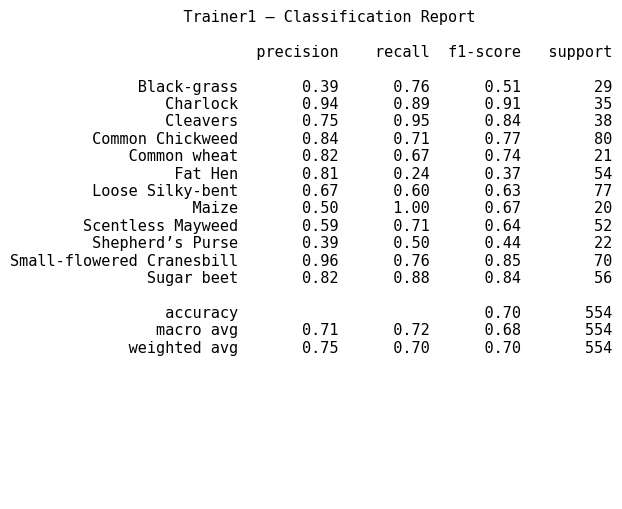

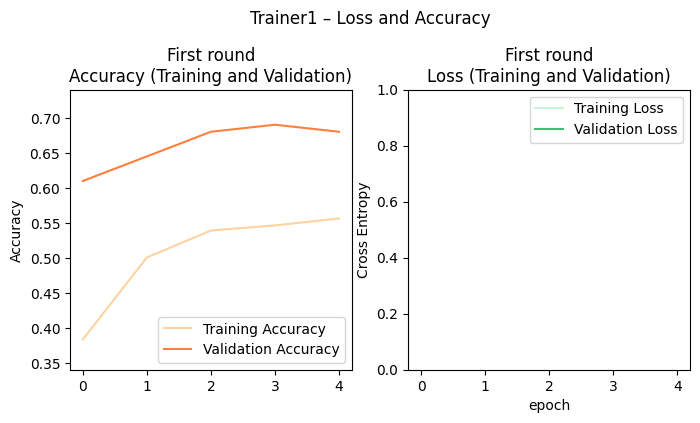

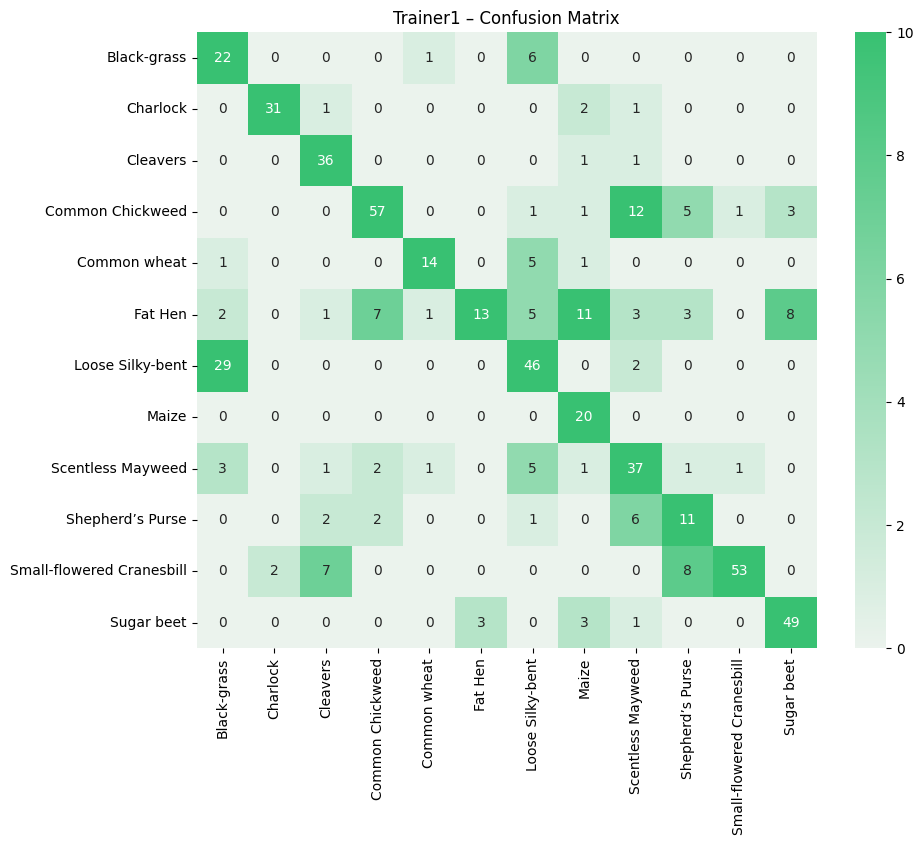

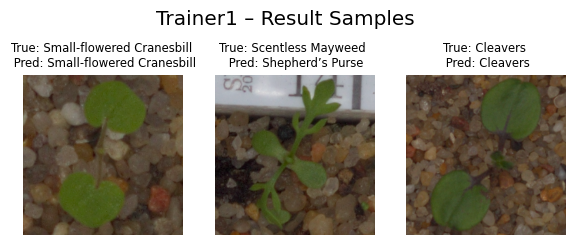

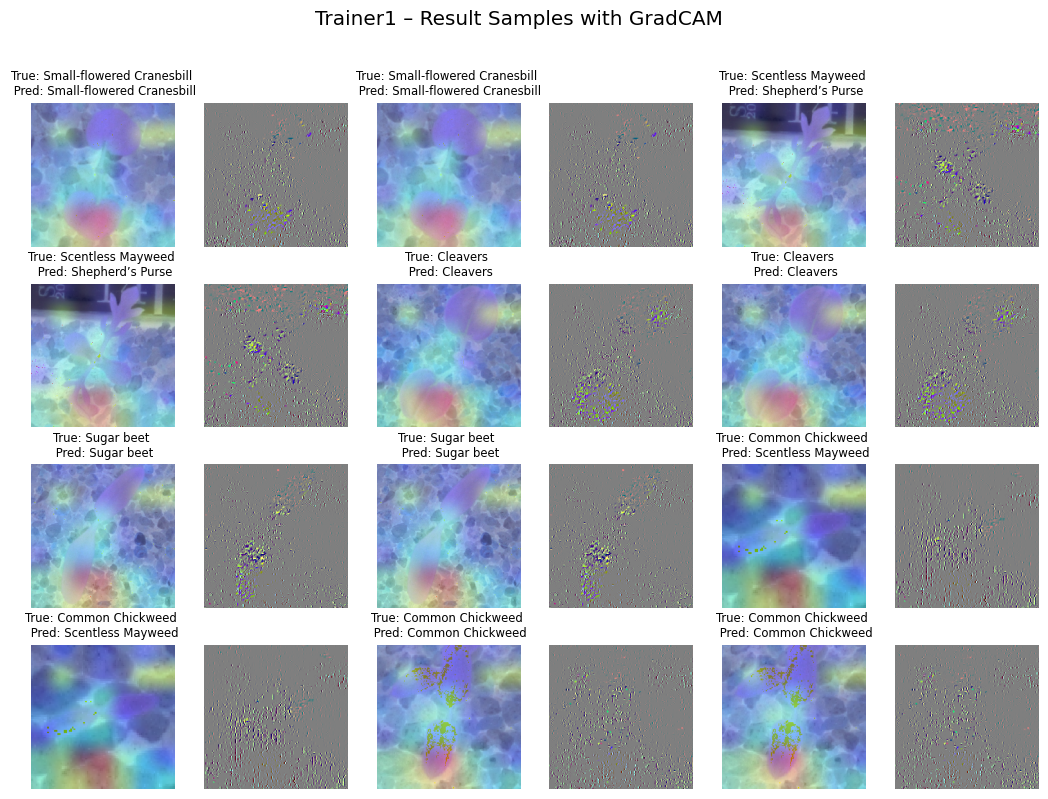

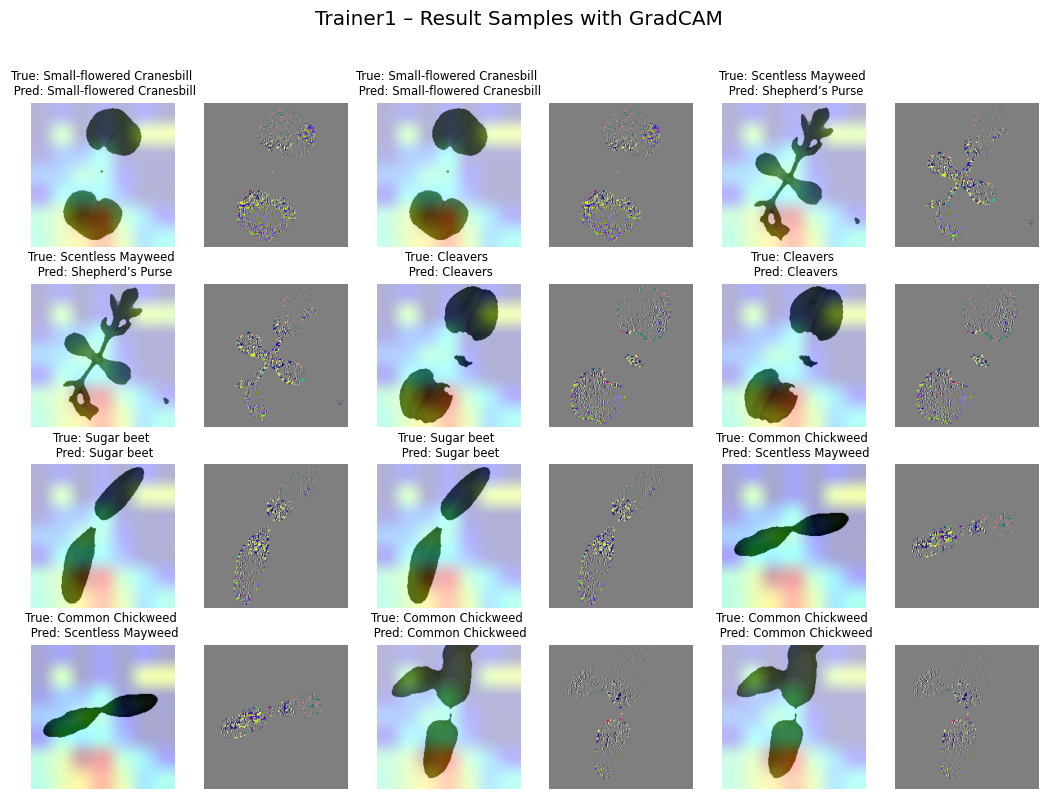

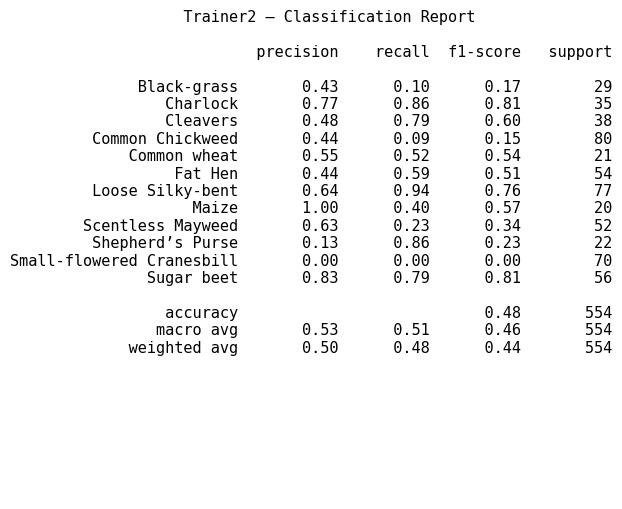

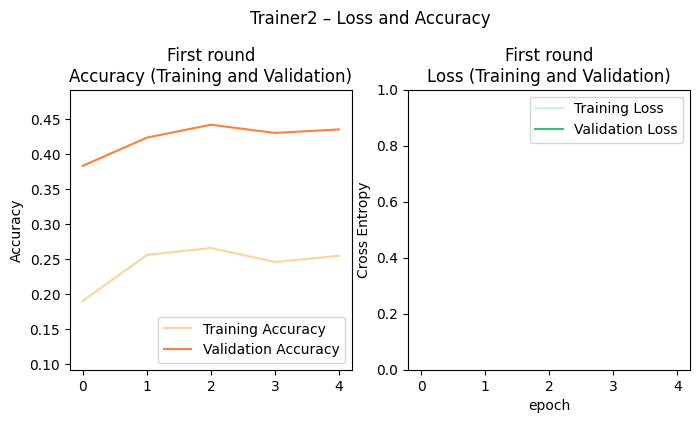

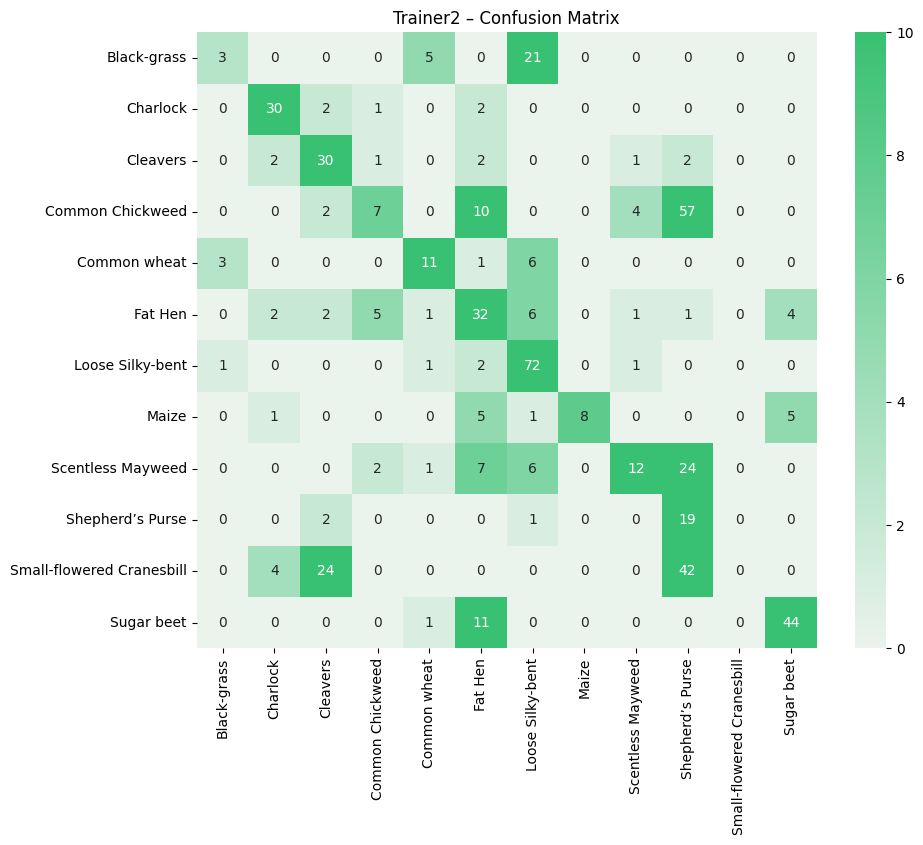

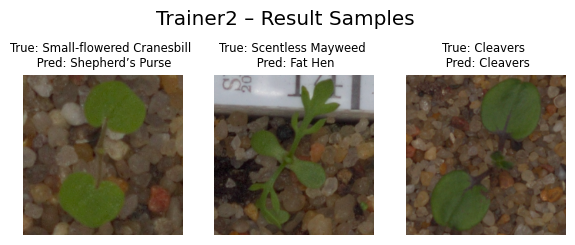

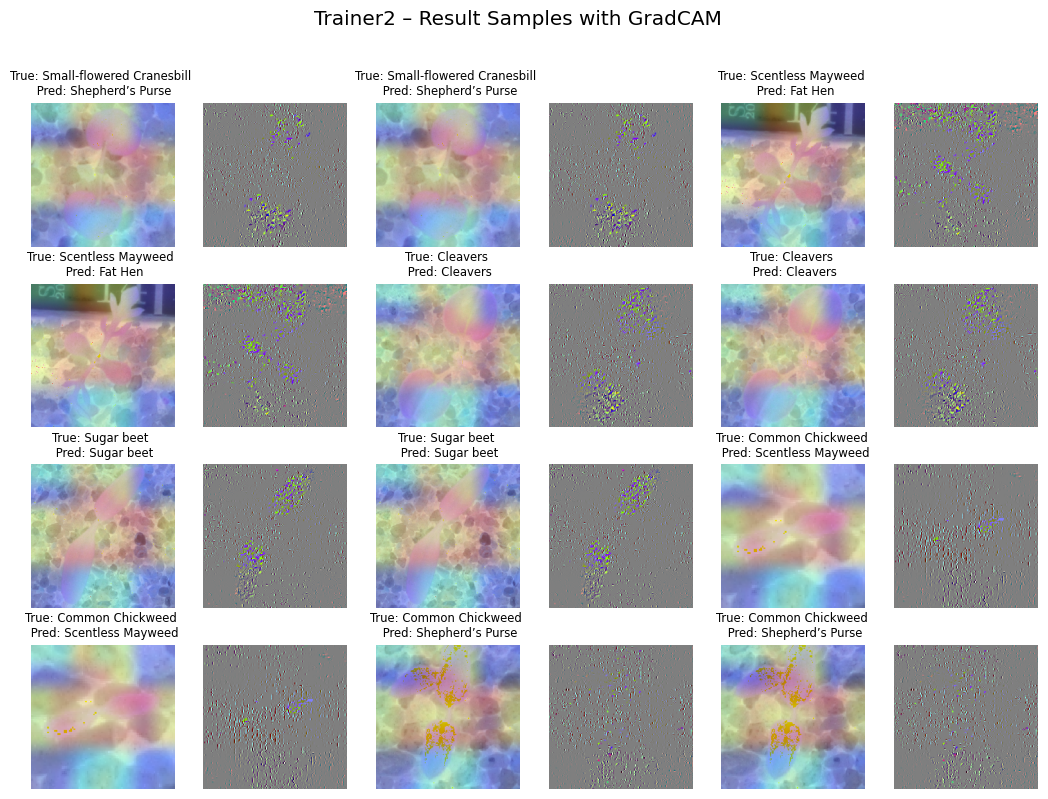

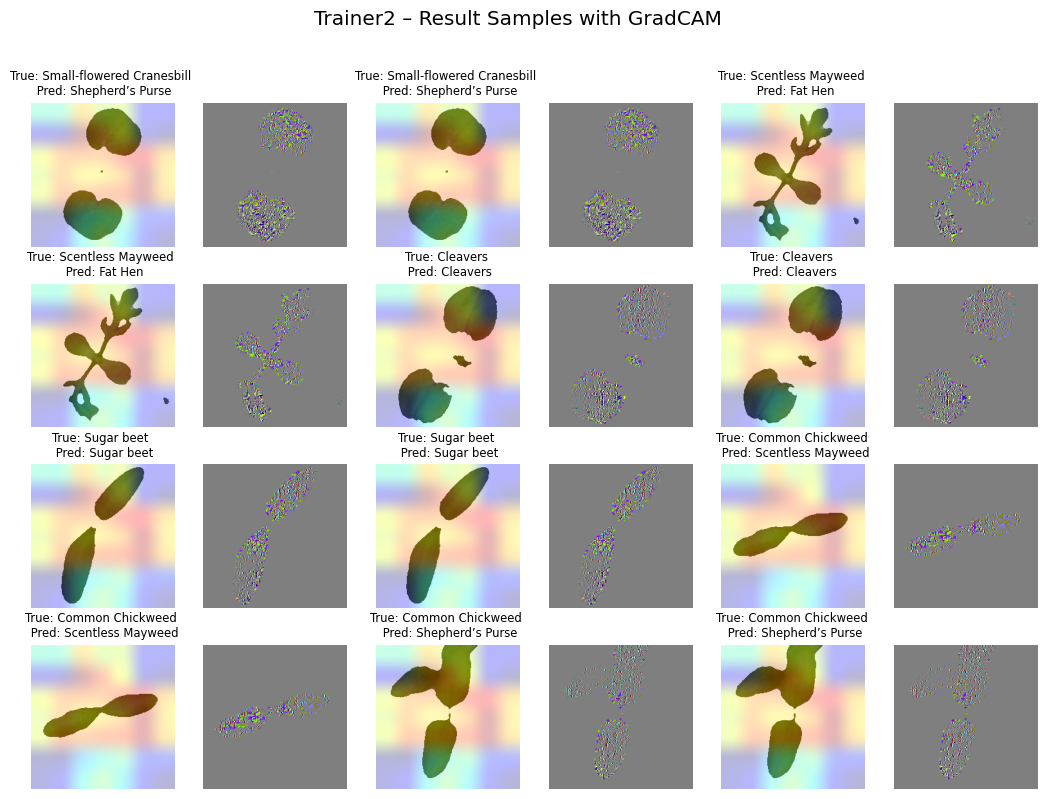

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [7]:
campaign.evaluate_and_build_reports()

# Autonomous exploration

Even if all reports have been generated and serialized, it is possible to see them in the notebook 

In [8]:
campaign.compare_models_performances()

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [9]:
campaign.compare_models_confusions()

It is also possible to manipulate directly the trained models.

>>> Trainer1 –– Display confusion matrix


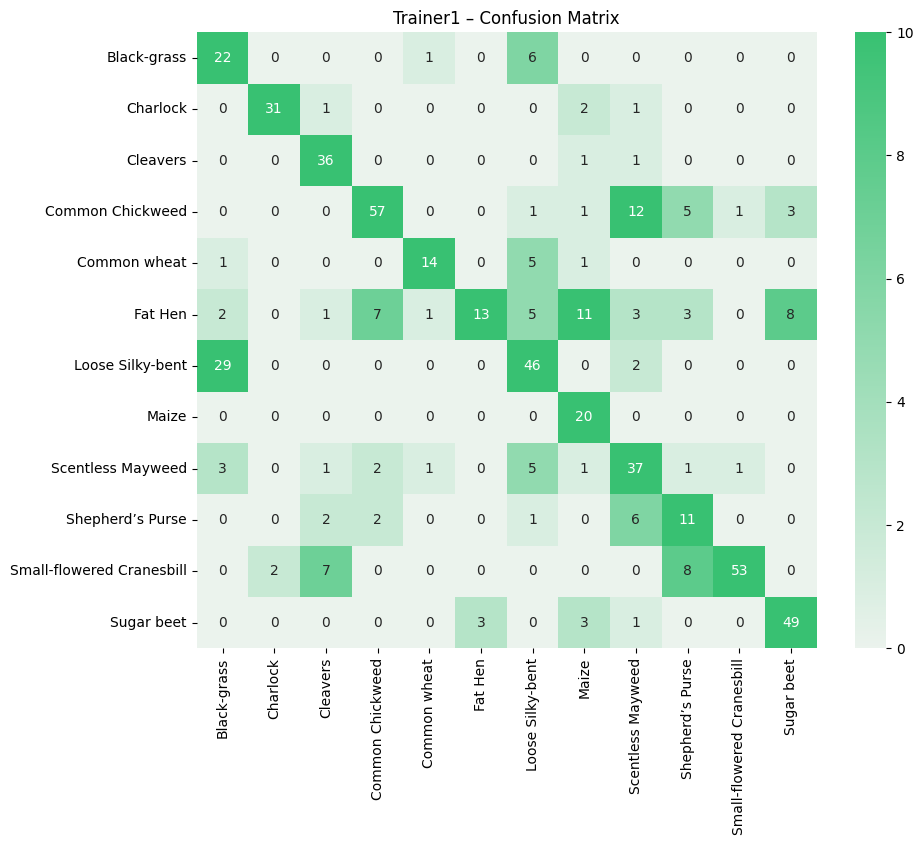

In [10]:
#Get the trainers 
trainers = campaign.active_models

trainers[0].display_confusion_matrix()

In [19]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
%matplotlib inline
from src.visualization.graphs import result_12_color_sequence, plotly_template

limit_finetuning = None
campaign_id= campaign.active_models[0].campaign_id
epoch_evolution = pd.DataFrame(columns=['model', 'epochs', 'loss', 'accuracy', 'val'])
for m in campaign.active_models:
    epoch1 = len(m.history1['loss'])
    for i in range(epoch1):
        epoch_evolution.loc[len(epoch_evolution)] = {
            'model': m.record_name, 'epochs': i + 1, 'loss': m.history1['loss'][i],
            'accuracy': m.history1['categorical_accuracy'][i], 'val': ''
        }
        epoch_evolution.loc[len(epoch_evolution)] = {
            'model': m.record_name, 'epochs': i + 1, 'loss': m.history1['val_loss'][i],
            'accuracy': m.history1['val_categorical_accuracy'][i], 'val': 'val'
        }
    if m.history2:
        for i in range(len(m.history2['loss'])):
            epoch_evolution.loc[len(epoch_evolution)] = {
                'model': m.record_name, 'epochs': i + epoch1 +1, 'loss': m.history2['loss'][i],
                'accuracy': m.history2['categorical_accuracy'][i], 'val': ''
            }
            epoch_evolution.loc[len(epoch_evolution)] = {
                'model': m.record_name, 'epochs': i + epoch1 + 1, 'loss': m.history2['val_loss'][i],
                'accuracy': m.history2['val_categorical_accuracy'][i], 'val': 'val'
            }
        limit_finetuning =epoch1


In [23]:
metric= 'accuracy'
plt.figure(figsize=(20, 10))
fig = px.line(data_frame=epoch_evolution, x='epochs', y=metric, line_dash='val', color='model',
              color_discrete_sequence=result_12_color_sequence, template=plotly_template, markers=True)
fig.update_traces(line={'width': 2})
if limit_finetuning:
    fig.add_vline(x=limit_finetuning, line_width=2, line_dash="dash", line_color="red")
fig.update_layout(title=f"{metric} evolution between models –– {campaign_id} campaign") 
pio.write_html(fig, f"test.html", auto_open=False)


<Figure size 2000x1000 with 0 Axes>